Load Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
import optuna
import shap
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, make_scorer


Load Processed Data

In [13]:
df = pd.read_csv('../Data/processed_data.csv')

Spltting the data in Train and Test

In [14]:

features = ['OxEnRa', 'BlFuPeIn', 'EnOxFl', 'CoBlFl', 'BlFuBoGaIn',
       'ThCoTe', 'EnOxPr', 'ToPrDr', 'HoBlPr', 'AcBlVe', 'CoBlTe', 'HoBlTe',
       'ToTe', 'BlHu', 'FoSI', 'FoSI_lag1', 'FoSI_lag2', 'FoSI_lag3',
       'ThCoTe_diff', 'FoSI_rolling3']
X = df[features]
y = df['SI']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Setting up the Model and traing on it

In [15]:
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4563, number of used features: 20
[LightGBM] [Info] Start training from score 0.464853
R²: 0.4049
RMSE: 0.0858
MAPE: 0.1449


Hypertunig Model

In [16]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True)
    }

    model = LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(r2_score)).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-08-11 14:50:17,226] A new study created in memory with name: no-name-d2a6c41c-fe41-45a5-a123-b0d60fca1462


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:19,645] Trial 0 finished with value: 0.31377359427934454 and parameters: {'n_estimators': 916, 'learning_rate': 0.0015912415085860413, 'max_depth': 9, 'num_leaves': 195, 'min_child_samples': 60, 'subsample': 0.5114938266601439, 'colsample_bytree': 0.6181249281794741, 'reg_alpha': 4.355476874821058, 'reg_lambda': 0.04158103042027721}. Best is trial 0 with value: 0.31377359427934454.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:21,154] Trial 1 finished with value: 0.34944140809318497 and parameters: {'n_estimators': 666, 'learning_rate': 0.17345080021877066, 'max_depth': 3, 'num_leaves': 295, 'min_child_samples': 61, 'subsample': 0.524126425412593, 'colsample_bytree': 0.869562849156148, 'reg_alpha': 0.12564713959101806, 'reg_lambda': 0.3030385250433177}. Best is trial 1 with value: 0.34944140809318497.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:50:22,279] Trial 2 finished with value: 0.3887567767796858 and parameters: {'n_estimators': 570, 'learning_rate': 0.01338719543031106, 'max_depth': 4, 'num_leaves': 208, 'min_child_samples': 90, 'subsample': 0.512740186765264, 'colsample_bytree': 0.5550877210257865, 'reg_alpha': 2.686577062865245, 'reg_lambda': 0.004806822488696401}. Best is trial 2 with value: 0.3887567767796858.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:24,979] Trial 3 finished with value: 0.4067928558644317 and parameters: {'n_estimators': 433, 'learning_rate': 0.024728124982138836, 'max_depth': 7, 'num_leaves': 270, 'min_child_samples': 23, 'subsample': 0.6722160254088366, 'colsample_bytree': 0.609236256256512, 'reg_alpha': 0.021352699060507886, 'reg_lambda': 0.0952655887493147}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:25,614] Trial 4 finished with value: 0.3810840792489783 and parameters: {'n_estimators': 146, 'learning_rate': 0.11000610050840329, 'max_depth': 9, 'num_leaves': 176, 'min_child_samples': 95, 'subsample': 0.5538636513243054, 'colsample_bytree': 0.6882177502252329, 'reg_alpha': 0.02796908821137208, 'reg_lambda': 1.5826832385260692}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[I 2025-08-11 14:50:27,245] Trial 5 finished with value: 0.38989426606025485 and parameters: {'n_estimators': 575, 'learning_rate': 0.0681062009533508, 'max_depth': 5, 'num_leaves': 80, 'min_child_samples': 51, 'subsample': 0.5130112485404712, 'colsample_bytree': 0.6921850167909445, 'reg_alpha': 0.907559834523473, 'reg_lambda': 0.00233600673718752}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:50:28,289] Trial 6 finished with value: 0.4021008156493912 and parameters: {'n_estimators': 183, 'learning_rate': 0.023308560379245346, 'max_depth': 12, 'num_leaves': 297, 'min_child_samples': 79, 'subsample': 0.6269431432633845, 'colsample_bytree': 0.6667353346270803, 'reg_alpha': 0.21008536549296583, 'reg_lambda': 2.6362308043074356}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Number of data points in the train set: 3651, number of used features: 20
[LightGBM] [Info] Start training from score 0.466245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2025-08-11 14:50:30,751] Trial 7 finished with value: 0.3742216933139515 and parameters: {'n_estimators': 824, 'learning_rate': 0.06074581738462298, 'max_depth': 7, 'num_leaves': 160, 'min_child_samples': 87, 'subsample': 0.5176277090247668, 'colsample_bytree': 0.6576057857648379, 'reg_alpha': 0.002170834850930146, 'reg_lambda': 0.005274274656074569}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:50:35,016] Trial 8 finished with value: 0.39321887264921684 and parameters: {'n_estimators': 643, 'learning_rate': 0.02276682350456962, 'max_depth': 15, 'num_leaves': 238, 'min_child_samples': 57, 'subsample': 0.7765445118489498, 'colsample_bytree': 0.5808414105532822, 'reg_alpha': 0.004880630880326128, 'reg_lambda': 1.4297153142855508}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:35,815] Trial 9 finished with value: 0.4029712733159406 and parameters: {'n_estimators': 105, 'learning_rate': 0.034114567277867436, 'max_depth': 10, 'num_leaves': 259, 'min_child_samples': 48, 'subsample': 0.8349802279685195, 'colsample_bytree': 0.7625428628677074, 'reg_alpha': 0.33508042048769054, 'reg_lambda': 0.8085842905631957}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3651, number of used features: 20
[LightGBM] [Info] Start training from score 0.466245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:38,228] Trial 10 finished with value: 0.38264021817016447 and parameters: {'n_estimators': 360, 'learning_rate': 0.005246005750965376, 'max_depth': 6, 'num_leaves': 98, 'min_child_samples': 8, 'subsample': 0.9770921939097621, 'colsample_bytree': 0.5027109078444553, 'reg_alpha': 0.017216089159730566, 'reg_lambda': 0.04410380857008528}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:42,278] Trial 11 finished with value: 0.4063311001401065 and parameters: {'n_estimators': 379, 'learning_rate': 0.009066031743135547, 'max_depth': 10, 'num_leaves': 255, 'min_child_samples': 24, 'subsample': 0.7879974457470913, 'colsample_bytree': 0.8220370894155802, 'reg_alpha': 0.47323210223776974, 'reg_lambda': 0.20431054813524674}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:50:50,396] Trial 12 finished with value: 0.4040909272524851 and parameters: {'n_estimators': 375, 'learning_rate': 0.006273904467184267, 'max_depth': 12, 'num_leaves': 245, 'min_child_samples': 18, 'subsample': 0.6839816222905157, 'colsample_bytree': 0.9367192707773264, 'reg_alpha': 0.027068225034338488, 'reg_lambda': 0.13859465120498993}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:50:53,483] Trial 13 finished with value: 0.39420464943088457 and parameters: {'n_estimators': 389, 'learning_rate': 0.006955301135473099, 'max_depth': 7, 'num_leaves': 139, 'min_child_samples': 27, 'subsample': 0.8565782172674588, 'colsample_bytree': 0.7852235680394539, 'reg_alpha': 0.787032123892546, 'reg_lambda': 9.341077006266243}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:51:03,412] Trial 14 finished with value: 0.256585159504927 and parameters: {'n_estimators': 445, 'learning_rate': 0.001177401622669166, 'max_depth': 11, 'num_leaves': 265, 'min_child_samples': 34, 'subsample': 0.7150504585939048, 'colsample_bytree': 0.8293342198514175, 'reg_alpha': 0.04856494604117578, 'reg_lambda': 0.02304348830920554}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start traini

[I 2025-08-11 14:51:27,027] Trial 15 finished with value: 0.34713426828382987 and parameters: {'n_estimators': 240, 'learning_rate': 0.00394315882656462, 'max_depth': 14, 'num_leaves': 222, 'min_child_samples': 5, 'subsample': 0.6362274796389747, 'colsample_bytree': 0.9761341585555658, 'reg_alpha': 0.007418505975783027, 'reg_lambda': 0.2512719768879895}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:51:32,266] Trial 16 finished with value: 0.4062228946720932 and parameters: {'n_estimators': 277, 'learning_rate': 0.010266928528846832, 'max_depth': 8, 'num_leaves': 52, 'min_child_samples': 33, 'subsample': 0.7908092634241455, 'colsample_bytree': 0.8808532257877475, 'reg_alpha': 0.0010461226758129202, 'reg_lambda': 0.0766617479224376}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:51:34,797] Trial 17 finished with value: 0.37074056662871097 and parameters: {'n_estimators': 713, 'learning_rate': 0.2870678265664253, 'max_depth': 13, 'num_leaves': 120, 'min_child_samples': 19, 'subsample': 0.9363559522202901, 'colsample_bytree': 0.7293918035539373, 'reg_alpha': 0.6730945522138629, 'reg_lambda': 0.012455976253375986}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-08-11 14:51:45,761] Trial 18 finished with value: 0.38296663865342595 and parameters: {'n_estimators': 503, 'learning_rate': 0.003222408442685214, 'max_depth': 10, 'num_leaves': 265, 'min_child_samples': 40, 'subsample': 0.8991325945051033, 'colsample_bytree': 0.8140489900602026, 'reg_alpha': 0.08813425551086962, 'reg_lambda': 0.4691029898982072}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:51:47,857] Trial 19 finished with value: 0.39780908202919574 and parameters: {'n_estimators': 300, 'learning_rate': 0.04090813188487975, 'max_depth': 6, 'num_leaves': 281, 'min_child_samples': 19, 'subsample': 0.7349621169869746, 'colsample_bytree': 0.7307733235729296, 'reg_alpha': 2.268074624147756, 'reg_lambda': 0.12153258464760025}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:51:56,697] Trial 20 finished with value: 0.3329034445313591 and parameters: {'n_estimators': 475, 'learning_rate': 0.0020582057017844817, 'max_depth': 8, 'num_leaves': 226, 'min_child_samples': 43, 'subsample': 0.6516108353608008, 'colsample_bytree': 0.8992410013217236, 'reg_alpha': 0.010489999134873067, 'reg_lambda': 5.769648374438503}. Best is trial 3 with value: 0.4067928558644317.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:52:00,865] Trial 21 finished with value: 0.40701686481327765 and parameters: {'n_estimators': 285, 'learning_rate': 0.013127671685236946, 'max_depth': 8, 'num_leaves': 39, 'min_child_samples': 30, 'subsample': 0.7840411246325908, 'colsample_bytree': 0.8524409931491232, 'reg_alpha': 0.0012009754539057664, 'reg_lambda': 0.055548688702469005}. Best is trial 21 with value: 0.40701686481327765.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:52:04,781] Trial 22 finished with value: 0.4026318103769805 and parameters: {'n_estimators': 232, 'learning_rate': 0.011194923422905869, 'max_depth': 8, 'num_leaves': 70, 'min_child_samples': 27, 'subsample': 0.8116139995371301, 'colsample_bytree': 0.8444772227083392, 'reg_alpha': 0.002802743245544061, 'reg_lambda': 0.02148929890908267}. Best is trial 21 with value: 0.40701686481327765.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:52:05,527] Trial 23 finished with value: 0.3666254205739084 and parameters: {'n_estimators': 320, 'learning_rate': 0.021607897418662307, 'max_depth': 10, 'num_leaves': 42, 'min_child_samples': 14, 'subsample': 0.7518364902549526, 'colsample_bytree': 0.9210890199129869, 'reg_alpha': 9.613272108961194, 'reg_lambda': 0.0792118584460603}. Best is trial 21 with value: 0.40701686481327765.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:52:07,800] Trial 24 finished with value: 0.40920908946764645 and parameters: {'n_estimators': 442, 'learning_rate': 0.009036563040425123, 'max_depth': 7, 'num_leaves': 25, 'min_child_samples': 29, 'subsample': 0.5985944758784238, 'colsample_bytree': 0.7968894917626553, 'reg_alpha': 0.0013980771197157908, 'reg_lambda': 0.1987989594261596}. Best is trial 24 with value: 0.40920908946764645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:52:09,328] Trial 25 finished with value: 0.40417794660035194 and parameters: {'n_estimators': 435, 'learning_rate': 0.016303275718487026, 'max_depth': 6, 'num_leaves': 23, 'min_child_samples': 71, 'subsample': 0.5866721160479975, 'colsample_bytree': 0.7841115395426115, 'reg_alpha': 0.001082003525338114, 'reg_lambda': 0.6170416553639647}. Best is trial 24 with value: 0.40920908946764645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:52:11,278] Trial 26 finished with value: 0.392043968197128 and parameters: {'n_estimators': 766, 'learning_rate': 0.039487879623283186, 'max_depth': 5, 'num_leaves': 24, 'min_child_samples': 36, 'subsample': 0.5951393521210324, 'colsample_bytree': 0.5011086763702414, 'reg_alpha': 0.004372263601614191, 'reg_lambda': 0.039790780306883454}. Best is trial 24 with value: 0.40920908946764645.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:52:15,103] Trial 27 finished with value: 0.4113572800662763 and parameters: {'n_estimators': 541, 'learning_rate': 0.016498473650187483, 'max_depth': 7, 'num_leaves': 102, 'min_child_samples': 11, 'subsample': 0.6923294946383551, 'colsample_bytree': 0.6130118314140272, 'reg_alpha': 0.002303841516451214, 'reg_lambda': 0.0010783250294657408}. Best is trial 27 with value: 0.4113572800662763.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from

[I 2025-08-11 14:52:18,093] Trial 28 finished with value: 0.377152631145539 and parameters: {'n_estimators': 527, 'learning_rate': 0.0025625416684052485, 'max_depth': 5, 'num_leaves': 101, 'min_child_samples': 12, 'subsample': 0.7018438015138931, 'colsample_bytree': 0.9650556589264138, 'reg_alpha': 0.0020345087876880827, 'reg_lambda': 0.0020356656287600183}. Best is trial 27 with value: 0.4113572800662763.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:52:26,770] Trial 29 finished with value: 0.40663617182236234 and parameters: {'n_estimators': 980, 'learning_rate': 0.004054874941351152, 'max_depth': 9, 'num_leaves': 54, 'min_child_samples': 30, 'subsample': 0.5874263160703108, 'colsample_bytree': 0.7526373629211294, 'reg_alpha': 0.0016376679632099079, 'reg_lambda': 0.0010695549154496936}. Best is trial 27 with value: 0.4113572800662763.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:52:35,757] Trial 30 finished with value: 0.41613152426332356 and parameters: {'n_estimators': 618, 'learning_rate': 0.008347548020287183, 'max_depth': 9, 'num_leaves': 77, 'min_child_samples': 5, 'subsample': 0.8687063849092455, 'colsample_bytree': 0.6093299288711495, 'reg_alpha': 0.004599812205414429, 'reg_lambda': 0.008757508965649365}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:52:41,072] Trial 31 finished with value: 0.4143777467808789 and parameters: {'n_estimators': 606, 'learning_rate': 0.015086292770264685, 'max_depth': 9, 'num_leaves': 74, 'min_child_samples': 11, 'subsample': 0.8621513980610251, 'colsample_bytree': 0.6087853256711205, 'reg_alpha': 0.0038274298683842215, 'reg_lambda': 0.005901310741344371}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:52:47,760] Trial 32 finished with value: 0.41442219151056936 and parameters: {'n_estimators': 609, 'learning_rate': 0.007814799679364538, 'max_depth': 9, 'num_leaves': 79, 'min_child_samples': 10, 'subsample': 0.8775611453140868, 'colsample_bytree': 0.6240666241702393, 'reg_alpha': 0.003818286920369095, 'reg_lambda': 0.008225592977133659}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:52:56,229] Trial 33 finished with value: 0.4140143500140924 and parameters: {'n_estimators': 632, 'learning_rate': 0.007253529543820513, 'max_depth': 11, 'num_leaves': 83, 'min_child_samples': 10, 'subsample': 0.881020522217915, 'colsample_bytree': 0.5504186582735312, 'reg_alpha': 0.003978878854553264, 'reg_lambda': 0.007722253293757407}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

[I 2025-08-11 14:53:06,856] Trial 34 finished with value: 0.4126462676200731 and parameters: {'n_estimators': 642, 'learning_rate': 0.007103031274677883, 'max_depth': 11, 'num_leaves': 75, 'min_child_samples': 6, 'subsample': 0.8927580114508867, 'colsample_bytree': 0.5725846928733411, 'reg_alpha': 0.009871270814860255, 'reg_lambda': 0.007644305136230342}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:53:19,641] Trial 35 finished with value: 0.4057158642890821 and parameters: {'n_estimators': 607, 'learning_rate': 0.004838588157130535, 'max_depth': 11, 'num_leaves': 122, 'min_child_samples': 15, 'subsample': 0.873581625575253, 'colsample_bytree': 0.54786002352332, 'reg_alpha': 0.004274845588316927, 'reg_lambda': 0.01004779119689188}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start traini

[I 2025-08-11 14:53:35,582] Trial 36 finished with value: 0.3775989802969352 and parameters: {'n_estimators': 725, 'learning_rate': 0.0019415104715319491, 'max_depth': 12, 'num_leaves': 84, 'min_child_samples': 5, 'subsample': 0.948594099685294, 'colsample_bytree': 0.6332540294431018, 'reg_alpha': 0.012224012642988839, 'reg_lambda': 0.003222006503588771}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:53:42,809] Trial 37 finished with value: 0.40911581023374693 and parameters: {'n_estimators': 695, 'learning_rate': 0.008033971387802251, 'max_depth': 9, 'num_leaves': 62, 'min_child_samples': 18, 'subsample': 0.915371289109338, 'colsample_bytree': 0.5350059511201368, 'reg_alpha': 0.006208954292080878, 'reg_lambda': 0.022948180194068146}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:53:44,299] Trial 38 finished with value: 0.4050007136869568 and parameters: {'n_estimators': 831, 'learning_rate': 0.014284952639336084, 'max_depth': 3, 'num_leaves': 149, 'min_child_samples': 11, 'subsample': 0.9898416632343155, 'colsample_bytree': 0.5853310305810807, 'reg_alpha': 0.04837940265323842, 'reg_lambda': 0.005324942646969293}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-11 14:53:47,284] Trial 39 finished with value: 0.39380447411478137 and parameters: {'n_estimators': 589, 'learning_rate': 0.029302601476351692, 'max_depth': 9, 'num_leaves': 87, 'min_child_samples': 68, 'subsample': 0.8394174159004334, 'colsample_bytree': 0.6401795565366142, 'reg_alpha': 0.003276874836215932, 'reg_lambda': 0.013518472354031917}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:54:00,210] Trial 40 finished with value: 0.40291982271349563 and parameters: {'n_estimators': 784, 'learning_rate': 0.003209577150666087, 'max_depth': 13, 'num_leaves': 121, 'min_child_samples': 22, 'subsample': 0.9556075787622551, 'colsample_bytree': 0.6965657081025967, 'reg_alpha': 0.04651868232396933, 'reg_lambda': 0.0026159072798711876}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00029

[I 2025-08-11 14:54:09,414] Trial 41 finished with value: 0.41584748229189133 and parameters: {'n_estimators': 648, 'learning_rate': 0.005988546960042336, 'max_depth': 11, 'num_leaves': 75, 'min_child_samples': 6, 'subsample': 0.886358475880355, 'colsample_bytree': 0.5795076404791502, 'reg_alpha': 0.009158892089185296, 'reg_lambda': 0.007146682805082479}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:54:19,613] Trial 42 finished with value: 0.4102980130016429 and parameters: {'n_estimators': 622, 'learning_rate': 0.004771390624070493, 'max_depth': 11, 'num_leaves': 94, 'min_child_samples': 11, 'subsample': 0.8773808141371072, 'colsample_bytree': 0.5987036006244066, 'reg_alpha': 0.016615667449883173, 'reg_lambda': 0.00697542578647126}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:54:30,576] Trial 43 finished with value: 0.4137814772126454 and parameters: {'n_estimators': 676, 'learning_rate': 0.006029828172045476, 'max_depth': 10, 'num_leaves': 113, 'min_child_samples': 8, 'subsample': 0.8252030141901624, 'colsample_bytree': 0.5568282261921923, 'reg_alpha': 0.007755499313304613, 'reg_lambda': 0.0035454301661215653}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:54:35,523] Trial 44 finished with value: 0.41070077975013897 and parameters: {'n_estimators': 568, 'learning_rate': 0.01111498443813457, 'max_depth': 9, 'num_leaves': 66, 'min_child_samples': 16, 'subsample': 0.9218493369590331, 'colsample_bytree': 0.5308061798421809, 'reg_alpha': 0.0035270995919087647, 'reg_lambda': 0.0016535188533766457}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-11 14:54:42,119] Trial 45 finished with value: 0.40131105815786244 and parameters: {'n_estimators': 746, 'learning_rate': 0.0197811837162473, 'max_depth': 10, 'num_leaves': 185, 'min_child_samples': 21, 'subsample': 0.8558146657589368, 'colsample_bytree': 0.6545480799249425, 'reg_alpha': 0.005226354580355066, 'reg_lambda': 0.016601183375744392}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

[I 2025-08-11 14:54:54,446] Trial 46 finished with value: 0.41609255891901376 and parameters: {'n_estimators': 855, 'learning_rate': 0.007620321551576973, 'max_depth': 12, 'num_leaves': 40, 'min_child_samples': 9, 'subsample': 0.8986566505600944, 'colsample_bytree': 0.6743999870265368, 'reg_alpha': 0.01327908327107051, 'reg_lambda': 0.004820250104529335}. Best is trial 30 with value: 0.41613152426332356.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start traini

[I 2025-08-11 14:55:06,743] Trial 47 finished with value: 0.4166306007869386 and parameters: {'n_estimators': 837, 'learning_rate': 0.012877273879274937, 'max_depth': 13, 'num_leaves': 36, 'min_child_samples': 5, 'subsample': 0.9174612050777412, 'colsample_bytree': 0.680867093132808, 'reg_alpha': 0.024303228336910187, 'reg_lambda': 0.0038647311692410306}. Best is trial 47 with value: 0.4166306007869386.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the 

[I 2025-08-11 14:55:21,216] Trial 48 finished with value: 0.41567298191113633 and parameters: {'n_estimators': 871, 'learning_rate': 0.012090538626942548, 'max_depth': 13, 'num_leaves': 44, 'min_child_samples': 6, 'subsample': 0.9080850600598627, 'colsample_bytree': 0.6748167193143827, 'reg_alpha': 0.03380245421532301, 'reg_lambda': 0.004164742004484318}. Best is trial 47 with value: 0.4166306007869386.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start training from score 0.464337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 20
[LightGBM] [Info] Start traini

[I 2025-08-11 14:55:29,236] Trial 49 finished with value: 0.4142187942620943 and parameters: {'n_estimators': 898, 'learning_rate': 0.01197454283628904, 'max_depth': 15, 'num_leaves': 35, 'min_child_samples': 5, 'subsample': 0.9636982720578932, 'colsample_bytree': 0.6808804430247026, 'reg_alpha': 0.10048105024501454, 'reg_lambda': 0.004180716041617397}. Best is trial 47 with value: 0.4166306007869386.


In [17]:
best_params = study.best_trial.params
model = LGBMRegressor(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4563, number of used features: 20
[LightGBM] [Info] Start training from score 0.464853
R²: 0.4192
RMSE: 0.0848
MAPE: 0.1428


Feature Importance with Shap Values

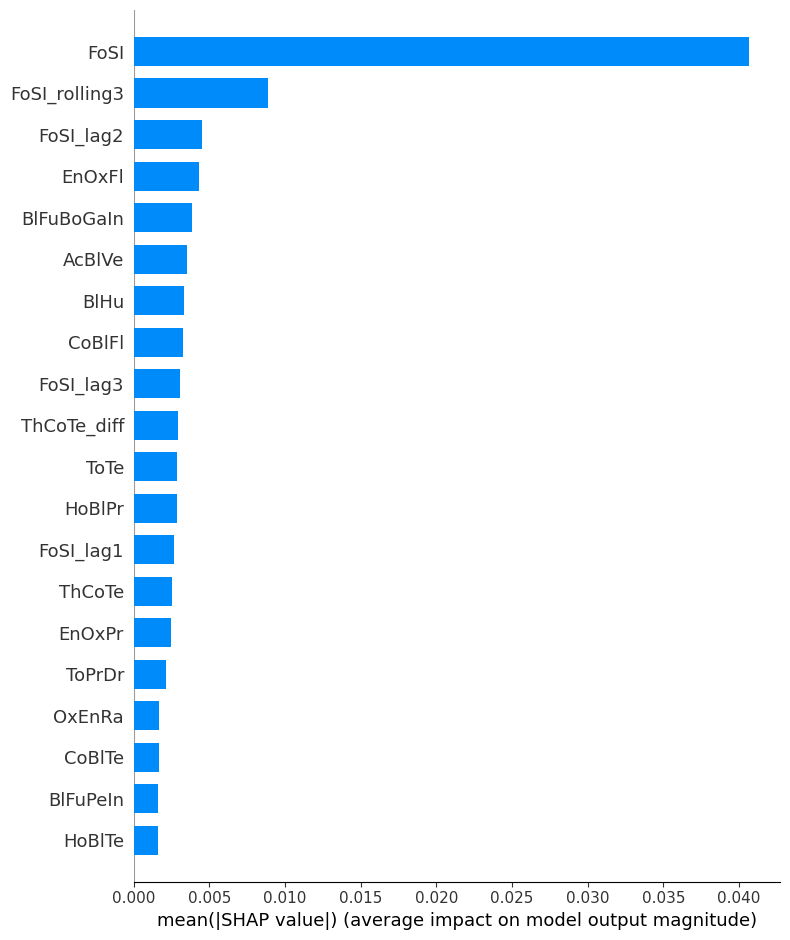

In [18]:
# Initialize TreeExplainer with your trained model
explainer = shap.TreeExplainer(model)  # model is your trained LGBMRegressor
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test, plot_type="bar")


Saving the Model Pickel File

In [20]:
joblib.dump(model, '../Models/SI_LGBM_model.pkl')

['../Models/SI_LGBM_model.pkl']